# Task 1 Notebook (Iris)
## Introduction
In this notebook, we'll be working with the cars dataset. We will first do some explanatory data analysis to understand the data. Then, we'll build some models to train on part of the data and be able to predict unseen data. In the end, we'll compare between the models to choose the best performing model.

### Explanatory data analysis

1. Importing packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

2. Importing data

In [5]:
cars = pd.read_csv(r"C:\Users\Admin\Downloads\car data.csv")
cars.head()

,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


3. Checking data info. This helps ensures data types and missing values.

In [7]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Driven_kms     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Selling_type   301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


We can see that data types are correct. In adddition, all columns contain 301 non-null data, which means there are no missing values since there are 301 entries.

4. Checking for any duplicate rows.

In [10]:
cars[cars.duplicated(keep=False)]

,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
15,ertiga,2016,7.75,10.79,43000,Diesel,Dealer,Manual,0
17,ertiga,2016,7.75,10.79,43000,Diesel,Dealer,Manual,0
51,fortuner,2015,23.00,30.61,40000,Diesel,Dealer,Automatic,0
93,fortuner,2015,23.00,30.61,40000,Diesel,Dealer,Automatic,0


There are 2 rows that are completely duplicated, so we should drop the duplicates.

In [12]:
cars.drop_duplicates(inplace=True)
cars.duplicated().sum()

0

5. Showing some data statistics with the describe method.

In [14]:
cars.describe()

,Year,Selling_Price,Present_Price,Driven_kms,Owner
count,299.000000,299.000000,299.000000,299.000000,299.000000
mean,2013.615385,4.589632,7.541037,36916.752508,0.043478
std,2.896868,4.984240,8.566332,39015.170352,0.248720
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.850000,1.200000,15000.000000,0.000000
50%,2014.000000,3.510000,6.100000,32000.000000,0.000000
75%,2016.000000,6.000000,9.840000,48883.500000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


6. Plotting a pairplot that shows the relationship between different features, in addition to the distribution of each feature on the diagonal axis. 

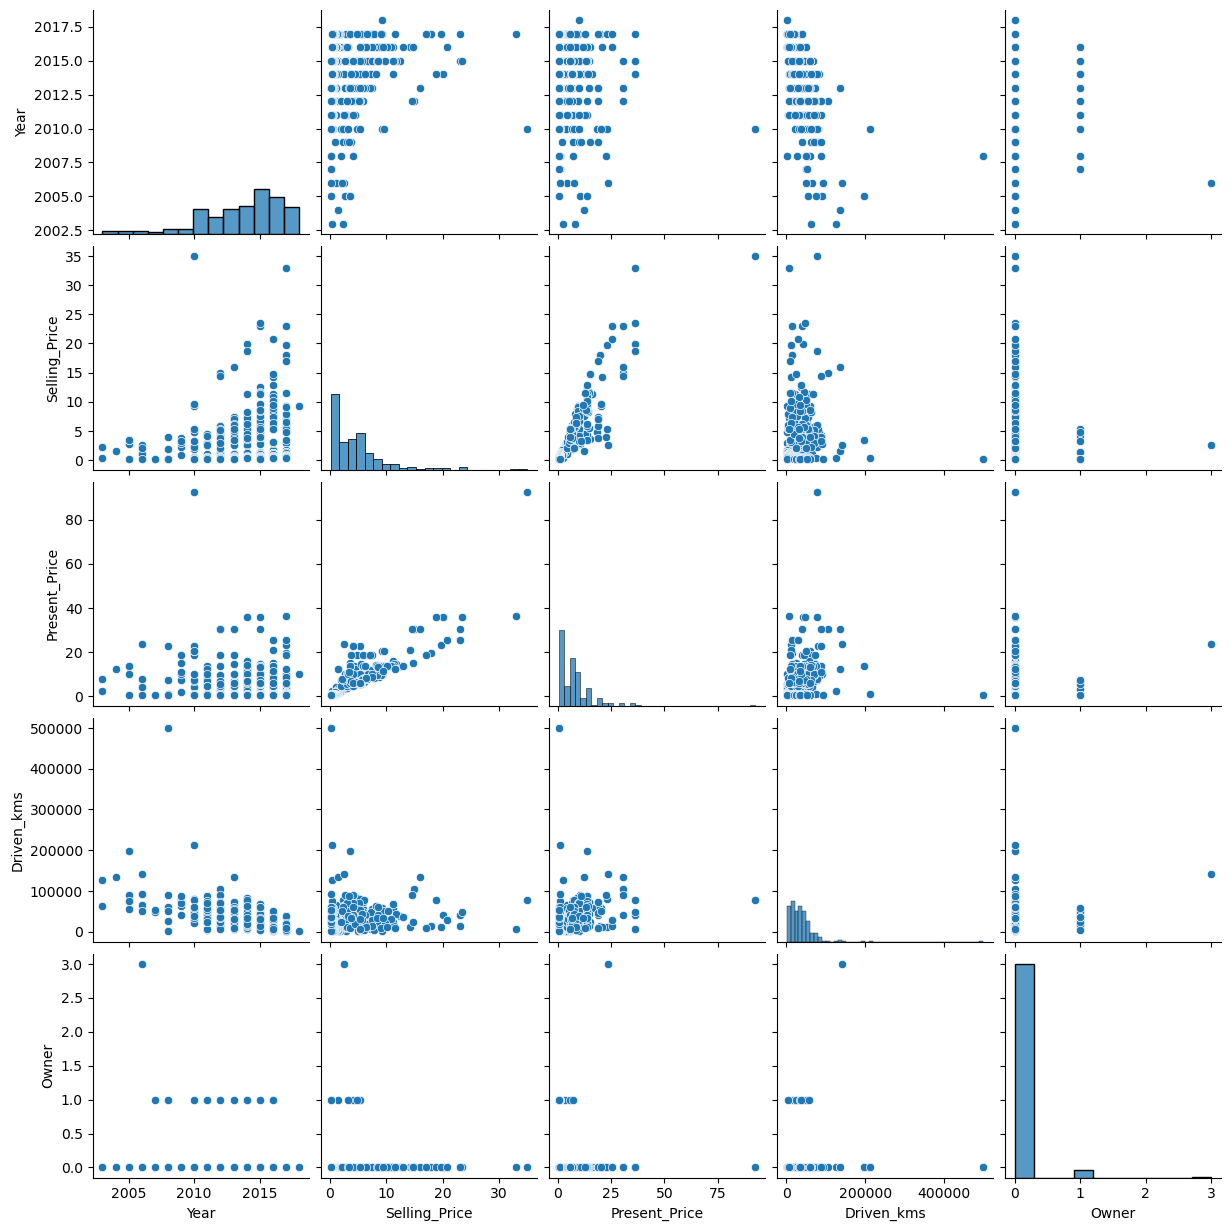

In [16]:
sns.pairplot(cars)
plt.show()

7. Plotting a heatmap of the correlation matrix between the features.

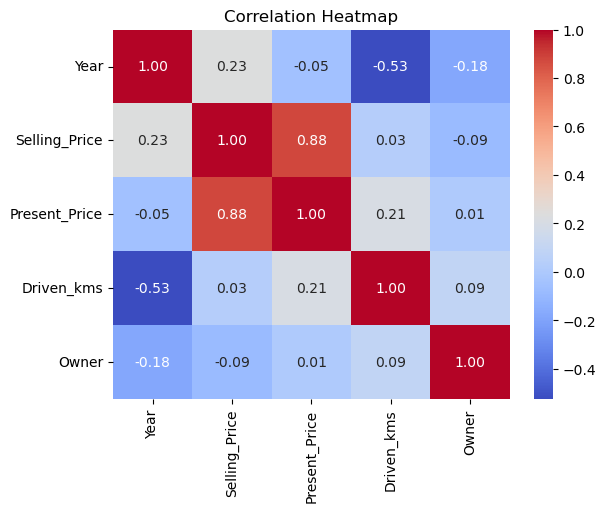

In [18]:
numerical_data = cars.select_dtypes('number')
correlation_matrix = numerical_data.corr()
sns.heatmap(correlation_matrix, annot=True ,cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

Looking at this correlation heatmap, we can that the relation between ***Present Price*** and ***Selling Price*** is positively high (0.88) which means it's a great feature to explain the target variable.

8. Visualize the distribution of numerical columns

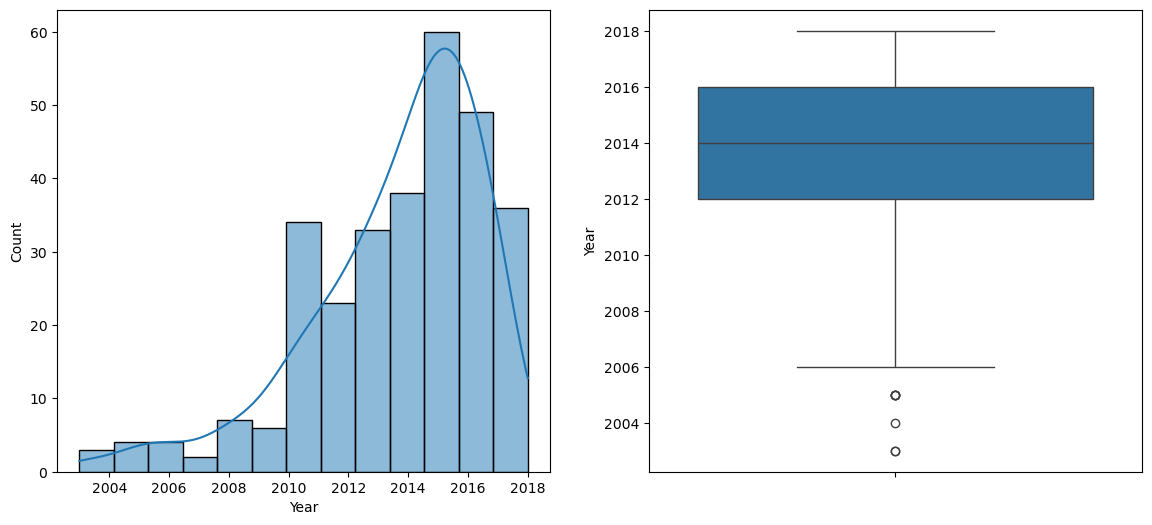

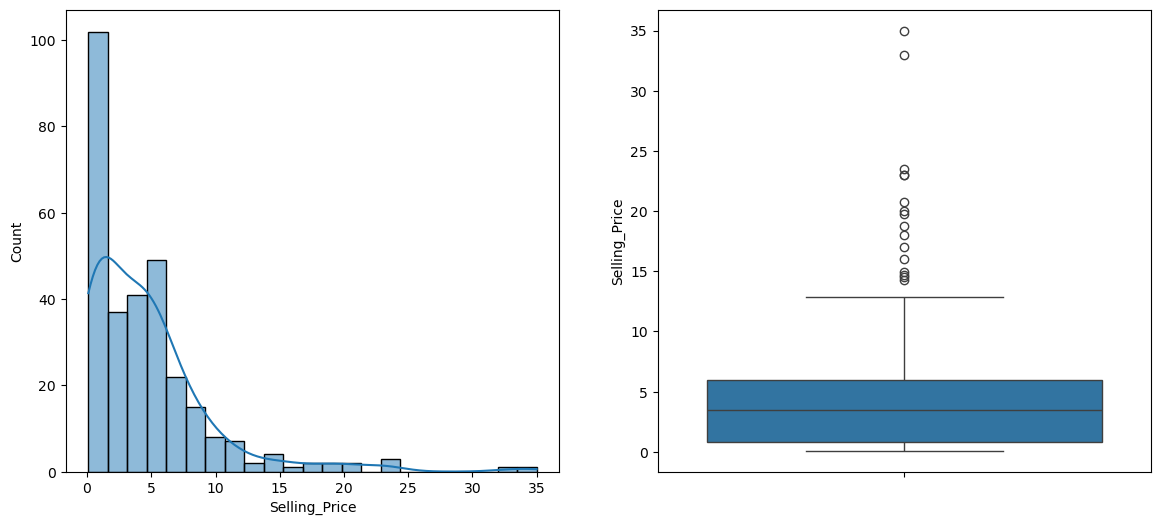

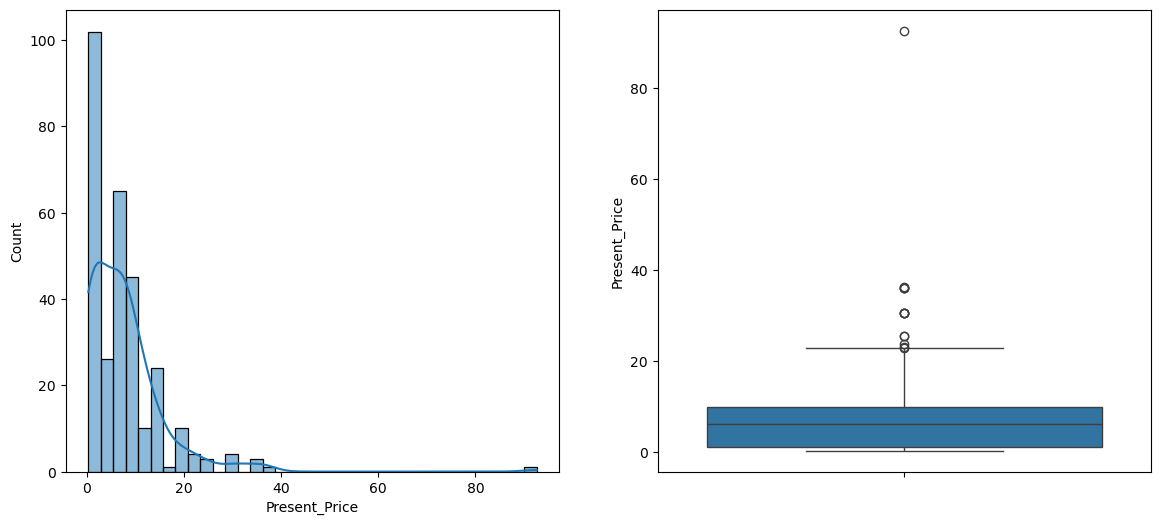

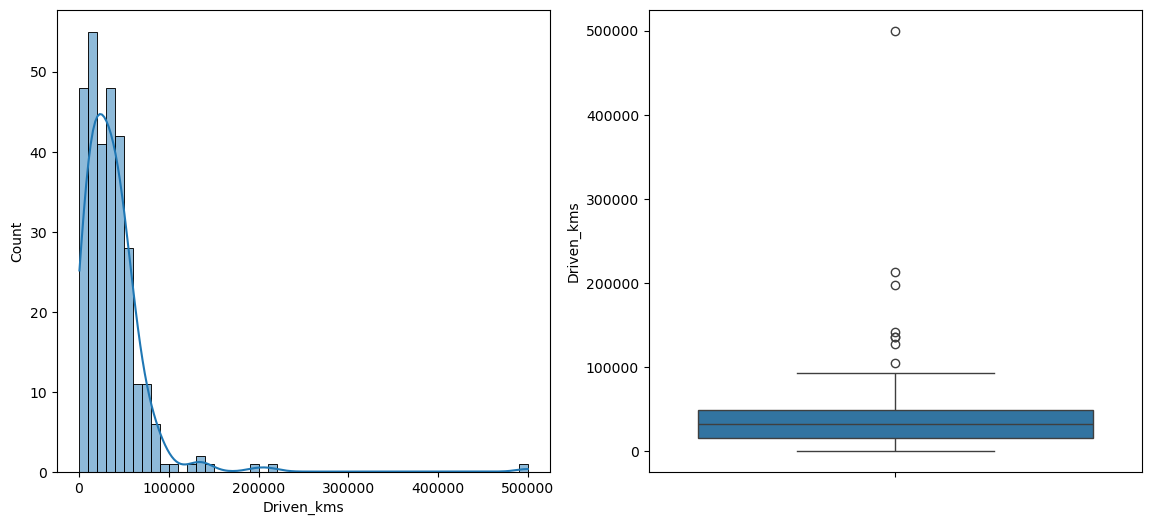

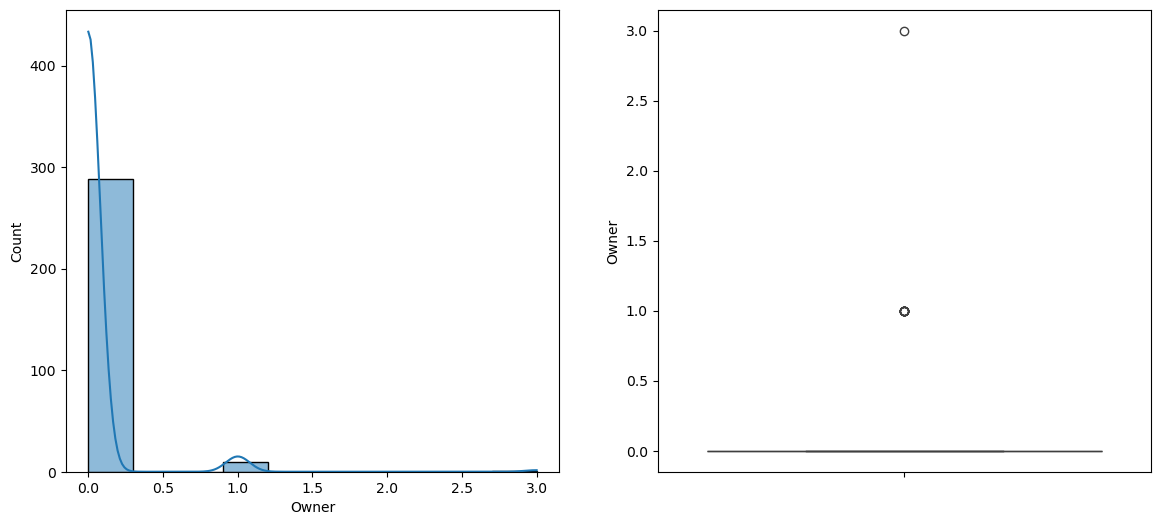

In [21]:
for col in numerical_data.columns:
    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    sns.histplot(cars[col], kde=True)
    plt.subplot(1,2,2)
    sns.boxplot(cars[col])
    plt.show()

9. Visualize the distribution of categorical columns

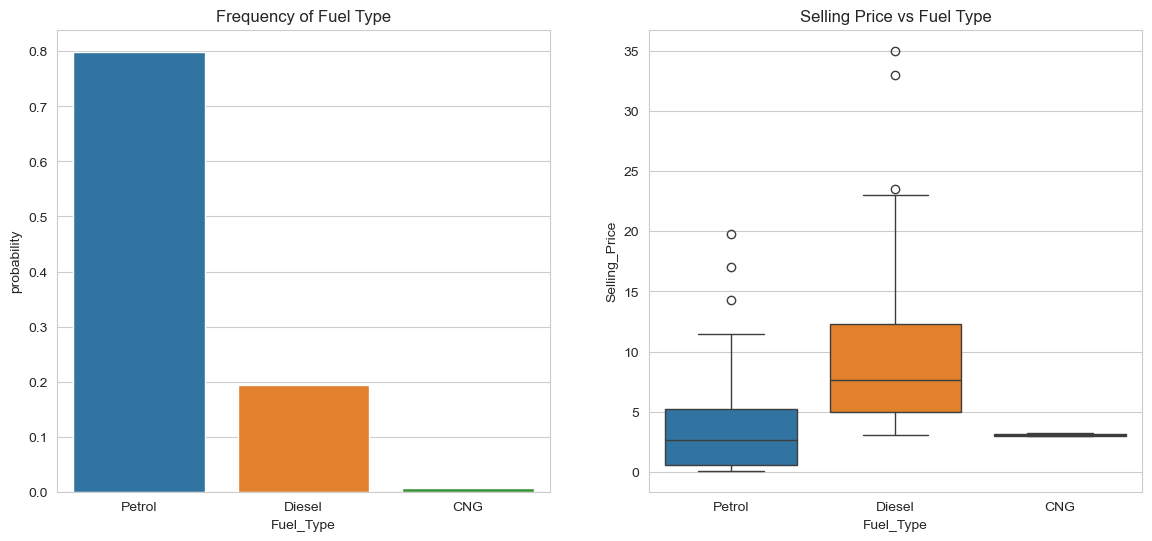

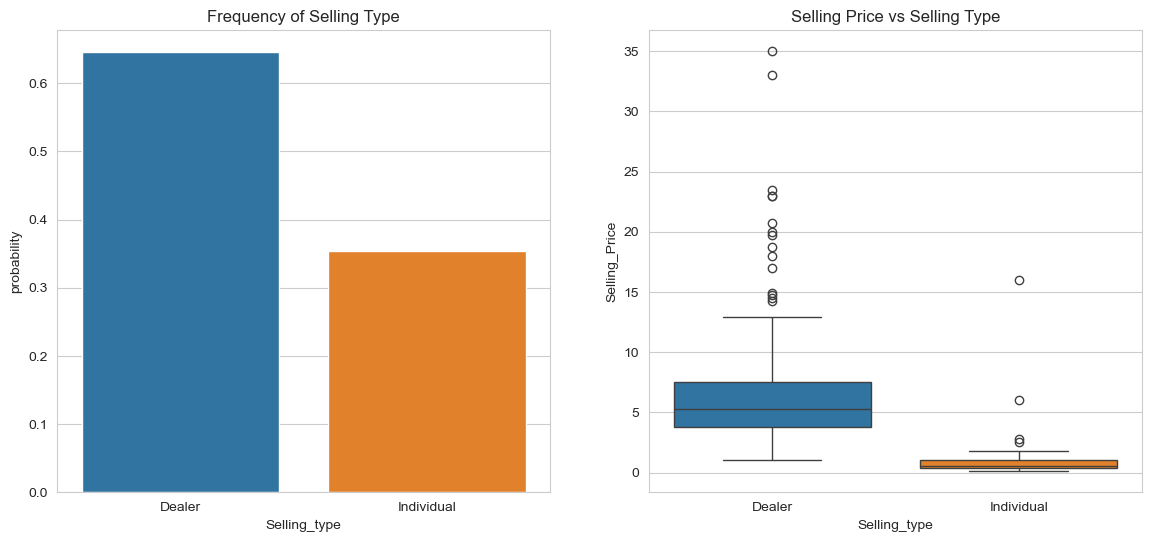

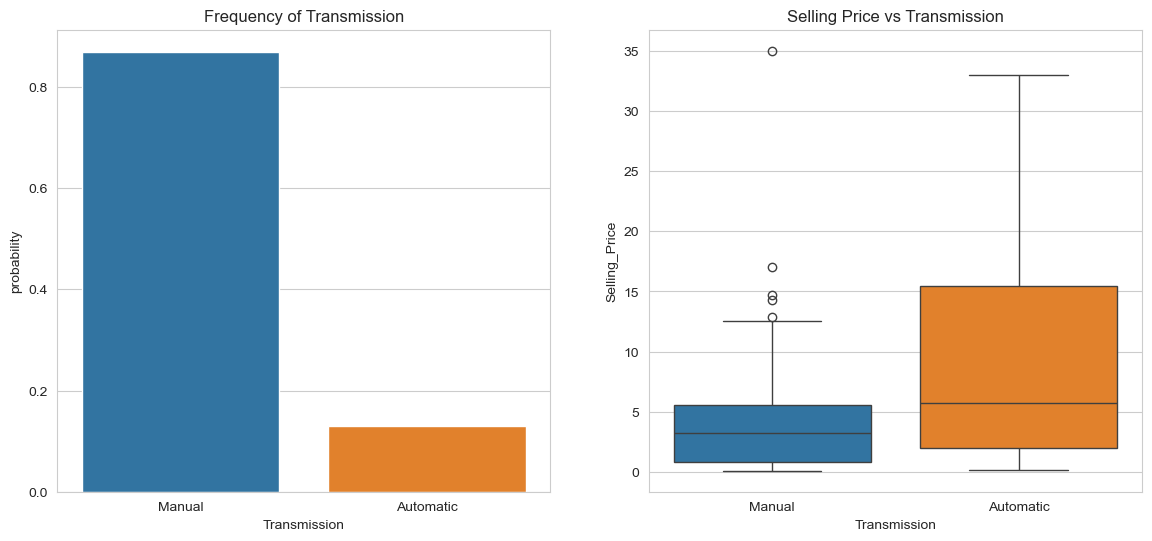

In [23]:
categorical_cols = cars.select_dtypes('object').drop('Car_Name', axis=1).columns
adjusted_col_names = [' '.join(s.split('_')).title() for s in categorical_cols]
for i, col in enumerate(categorical_cols):
    plt.figure(figsize=(14,6))
    sns.set_style('whitegrid')
    plt.subplot(1,2,1)
    sns.countplot(data=cars, x=col, stat='probability', hue=col)
    plt.title(f'Frequency of {adjusted_col_names[i]}')
    plt.subplot(1,2,2)
    sns.boxplot(data=cars, x=col, y='Selling_Price', hue= col)
    plt.title(f'Selling Price vs {adjusted_col_names[i]}')
    plt.show()

10. Visualize the top cars by selling price

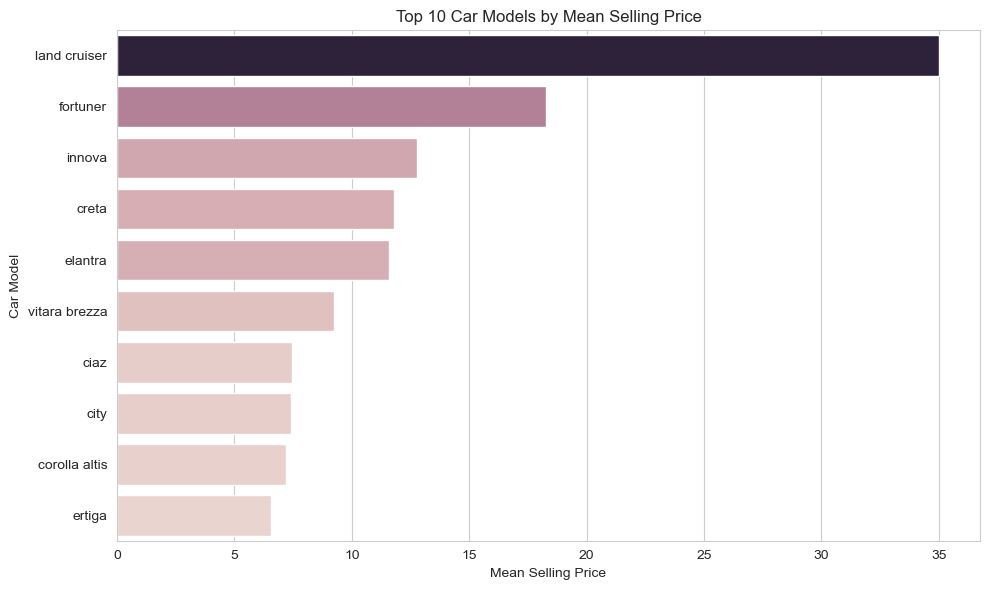

In [25]:
top_car_models = cars.groupby('Car_Name')['Selling_Price'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_car_models.values, y=top_car_models.index, hue=top_car_models.values, legend=False)
plt.title(f'Top {10} Car Models by Mean Selling Price')
plt.xlabel('Mean Selling Price')
plt.ylabel('Car Model')
plt.tight_layout()
plt.show()

11. Investigate the correlation between the different groups of categorical columns and ***Selling Price*** with non-parametric tests.

In [27]:
def significance(df, col, target):
    n_unique = df[col].nunique()
    groups = [df[df[col] == value][target] for value in df[col].unique()]
    sig_level = 0.05
    if n_unique > 2:
        ## Perform Kruskal-Wallis Test
        h_stat, p_value = stats.kruskal(*groups)
        print(f'----> Results of the Kruskal-Wallis Test on the "{col}" column:')
        print(f'H-statistic: {h_stat:.2f}, P-value: {p_value}\n')
    elif n_unique == 2:
        ## perform mann_whitney_test
        u_stat, p_value = stats.mannwhitneyu(*groups, alternative='two-sided')
        print(f'---> Results of the mann_whitney_test on the "{col}" column:')
        print(f'U-statistic: {u_stat:.2f}, P-value: {p_value}\n')
    if p_value < sig_level:
        print('The p_value is lower than the significane level of 0.05.')
        print('This means there is a significant difference in the mean of the different categories.')
    else:
        print('The p_value is greater than the significane level of 0.05.')
        print('This means there is no significant difference in the mean of the different categories.')
    print('_____________________________________________________________________________________________')

for col in categorical_cols:
    significance(cars, col,'Selling_Price')
    print()

----> Results of the Kruskal-Wallis Test on the "Fuel_Type" column:
H-statistic: 75.39, P-value: 4.2493611686155344e-17

The p_value is lower than the significane level of 0.05.
This means there is a significant difference in the mean of the different categories.
_____________________________________________________________________________________________

---> Results of the mann_whitney_test on the "Selling_type" column:
U-statistic: 20094.00, P-value: 2.752262715346023e-43

The p_value is lower than the significane level of 0.05.
This means there is a significant difference in the mean of the different categories.
_____________________________________________________________________________________________

---> Results of the mann_whitney_test on the "Transmission" column:
U-statistic: 3512.00, P-value: 0.001977155835660129

The p_value is lower than the significane level of 0.05.
This means there is a significant difference in the mean of the different categories.
________________

The results of the non-parametric tests show that the difference in the target variable ***Selling Price*** among the groups of explanatory categorical variables is significant, which means there's good correlation between the categories and the target ***Selling Price***.

### Preparing for running models.

1. Creating dummy variables and preparing data. I log-transformed the ***Driven kms***, ***Present Price***, and ***Selling Price*** columns, so that they follow a normal distribution better. This helps the models to train on the data.

In [31]:
cars_dummy = pd.get_dummies(cars, columns=categorical_cols, drop_first=True)

cars_dummy['Driven_kms_log'] = np.log1p(cars_dummy['Driven_kms'])
cars_dummy['Selling_Price_log'] = np.log1p(cars_dummy['Selling_Price'])
cars_dummy['Present_Price_log'] = np.log1p(cars_dummy['Present_Price'])

X = cars_dummy.drop(['Car_Name','Selling_Price','Driven_kms','Selling_Price_log','Present_Price'], axis=1)
y = cars_dummy['Selling_Price_log']

2. Perform a lasso test for feature importance

Lasso detected "Present_Price_log" as the top predicting feature.



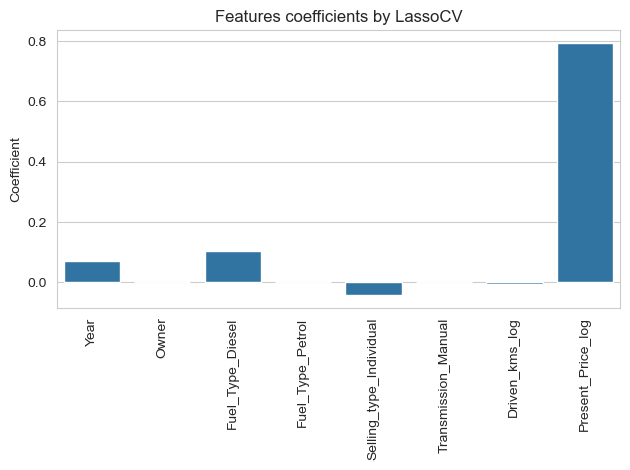

In [33]:
lasso = LassoCV(cv=5, random_state=27)
lasso_coef = lasso.fit(X, y).coef_
coef = pd.Series(lasso_coef, index=X.columns)
top_features = coef[coef.abs()>0.25].index.tolist()
print(f'Lasso detected "{top_features[0]}" as the top predicting feature.')
print()
sns.barplot(x=X.columns, y=lasso_coef)
plt.xticks(rotation='vertical')
plt.ylabel('Coefficient'), plt.xlabel('')
plt.title('Features coefficients by LassoCV')
plt.tight_layout()
plt.show()

3. Correlation between numerical columns and ***Selling Price log***

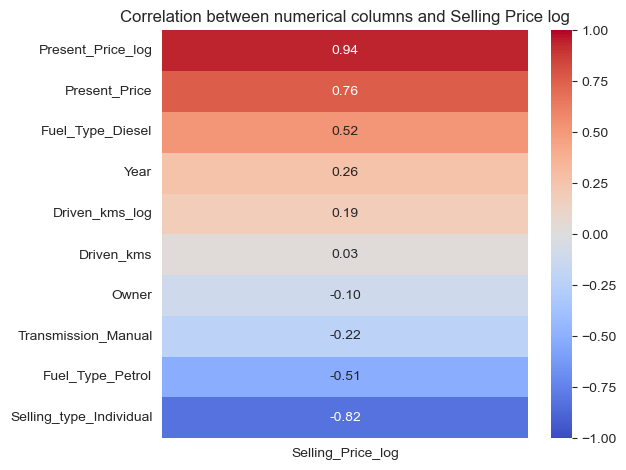

In [35]:
features = cars_dummy.drop(['Car_Name','Selling_Price'], axis=1)
Cor = features.corr()['Selling_Price_log'].drop('Selling_Price_log').sort_values(ascending=False)
data = pd.DataFrame(Cor)
sns.heatmap(data, annot=True, fmt='.2f', cmap='coolwarm',vmin=-1, vmax=1)
plt.title('Correlation between numerical columns and Selling Price log')
plt.tight_layout()
plt.show()

- We can see that ***Present Price log*** has the highest positive correlation with the target variable ***Selling Price Price***. Also, ***Selling Type Individual*** has the highest negative correlation.
- We can see how the *log-transoformed* explanatory variables show higher correlation with the target than the original columns, so we'll use them instead as the explanatory features.

##### ---> Creating a performance dictionary to store each model performance

In [38]:
performance = {'Metrics':['Training MSE','Test MSE','Traning R2','Test R2']}

### Linear Regression
After splitting data into train and test sets, we'll use cross-validation to ensure the model trains and generalizes well to unseen data on different folds of the data.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)
kf = KFold(n_splits=6, random_state=27, shuffle=True)
reg = LinearRegression()
scoring = {'r2': 'r2', 'mse': 'neg_mean_squared_error'}
cv_results = cross_validate(reg, X_train, y_train, cv=kf, scoring=scoring, return_train_score=True)
## Extract and print the training and test scores for each fold
r2_train_scores = cv_results['train_r2']
r2_test_scores = cv_results['test_r2']
mse_train_scores = -cv_results['train_mse']
mse_test_scores = -cv_results['test_mse']

print('Results of Linear Regression cross-validation')
print(f'Mean Training R2 Score: {r2_train_scores.mean():.2f}')
print(f'Mean Test R2 Score: {r2_test_scores.mean():.2f}')
print(f'Mean Training MSE: {mse_train_scores.mean():.2f}')
print(f'Mean Test MSE: {mse_test_scores.mean():.2f}')

Results of Linear Regression cross-validation
Mean Training R2 Score: 0.97
Mean Test R2 Score: 0.95
Mean Training MSE: 0.02
Mean Test MSE: 0.03


Visualize the performance of the model with a boxplot of R2 score and MSE for training and test data after cross validation

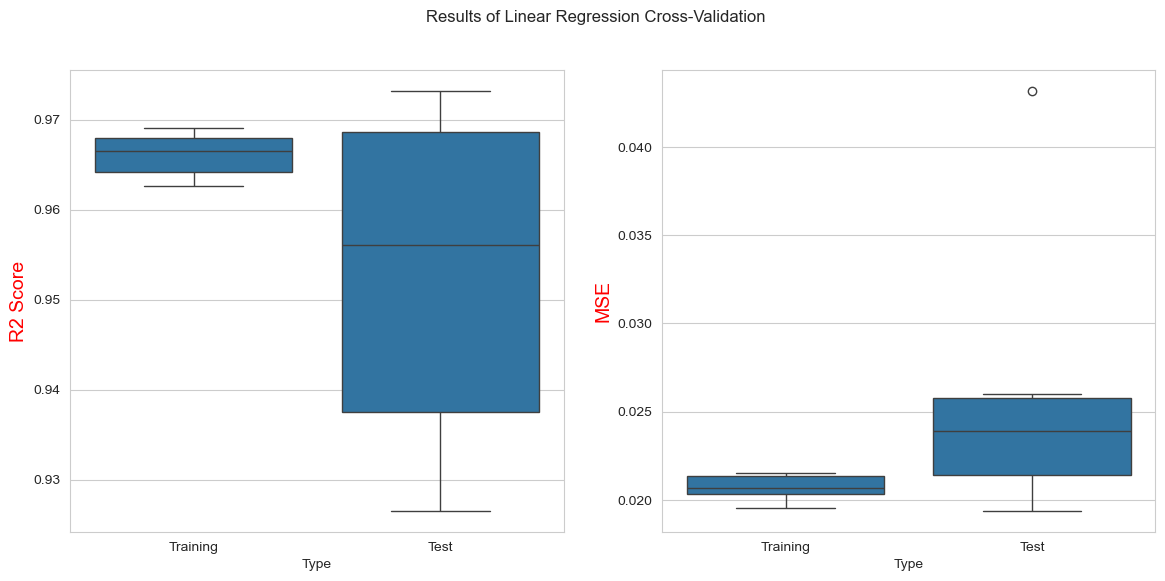

In [42]:
reg_data = pd.DataFrame({'R2 Score': list(r2_train_scores) + list(r2_test_scores),
                         'MSE': list(mse_train_scores) + list(mse_test_scores),
                         'Type':['Training']*6 + ['Test']*6})
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.boxplot(data=reg_data, x='Type', y='R2 Score')
plt.ylabel('R2 Score', fontsize=14, color='red')
plt.subplot(1,2,2)
sns.boxplot(data=reg_data, x='Type', y='MSE')
plt.ylabel('MSE', fontsize=14, color='red')
plt.suptitle('Results of Linear Regression Cross-Validation')
plt.show()

---> Adding the performance of the Linear Regression model to the perforamce dictionary.

In [44]:
performance['Linear Regression'] = [round(mse_train_scores.mean(),3), round(mse_test_scores.mean(),3),
                                    round(r2_train_scores.mean(),3), round(r2_test_scores.mean(),3)]

### Ridge regularization
Tuning ridge with cross-validation:

In [46]:
ridge_cv = RidgeCV(cv=5)
ridge_cv.fit(X_train, y_train)
y_pred_train = ridge_cv.predict(X_train)
y_pred_test = ridge_cv.predict(X_test)
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
print('Results of Ridge after tuning and cross-validation')
print(f"Training MSE: {train_mse:.3f}")
print(f"Testing MSE: {test_mse:.3f}")
print(f"Training R2 Score: {train_r2:.3f}")
print(f"Testing R2 Score: {test_r2:.3f}")

Results of Ridge after tuning and cross-validation
Training MSE: 0.021
Testing MSE: 0.026
Training R2 Score: 0.966
Testing R2 Score: 0.964


---> Adding the performance of the Ridge regularization to the perforamce dictionary.

In [48]:
performance['Ridge'] = [round(train_mse,3),round(test_mse,3),round(train_r2,3),round(test_r2,3)]

### KNN Regressor
We'll first tune the model to choose the best k (number of neighbors) to run the model. Then we'll take the results of the best model.

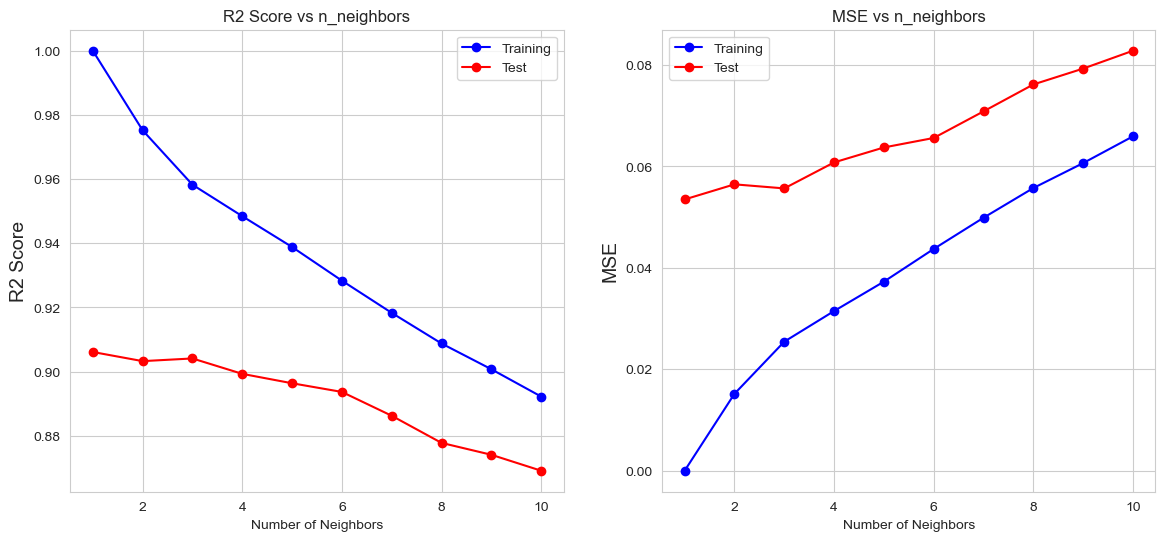

In [50]:
train_mse_values = []
train_r2_values = []
test_mse_values = []
test_r2_values = []
scoring = {'r2': 'r2', 'mse': 'neg_mean_squared_error'}
neighbors = [_ for _ in range(1,11)]
for k in neighbors:
    knn = KNeighborsRegressor(n_neighbors=k)
    cv_results = cross_validate(knn, X_train, y_train, cv=kf, scoring=scoring, return_train_score=True)
    train_mse_values.append(-cv_results['train_mse'].mean())
    test_mse_values.append(-cv_results['test_mse'].mean())
    train_r2_values.append(cv_results['train_r2'].mean())
    test_r2_values.append(cv_results['test_r2'].mean())

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(neighbors, train_r2_values, label='Training', marker='o', c='b')
plt.plot(neighbors, test_r2_values, label='Test', marker='o', c='r')
plt.xlabel('Number of Neighbors')
plt.ylabel('R2 Score', fontsize=14)
plt.title('R2 Score vs n_neighbors')
plt.legend()
plt.subplot(1,2,2)
plt.plot(neighbors, train_mse_values, label='Training', marker='o', c='b')
plt.plot(neighbors, test_mse_values, label='Test', marker='o', c='r')
plt.xlabel('Number of Neighbors')
plt.ylabel('MSE', fontsize=14)
plt.title('MSE vs n_neighbors')
plt.legend()

In [51]:
print('Knn performs best with n_neighbors equal to 3:')
print(f"Training MSE: {train_mse_values[2]:.3f}")
print(f"Testing MSE: {test_mse_values[2]:.3f}")
print(f"Training R2 Score: {train_r2_values[2]:.3f}")
print(f"Testing R2 Score: {test_r2_values[2]:.3f}")

Knn performs best with n_neighbors equal to 3:
Training MSE: 0.025
Testing MSE: 0.056
Training R2 Score: 0.958
Testing R2 Score: 0.904


---> Adding the performance of the KNN Regressor to the perforamce dictionary.

In [53]:
performance['KNN'] = [round(train_mse_values[2],3), round(test_mse_values[2],3),
                      round(train_r2_values[2],3), round(test_r2_values[2],3)]

### Decision Tree Regressor
We'll tune the model and choose the best hyperparameters using GridSearchCV. Then we'll take the results of the best model.

In [55]:
DTR = DecisionTreeRegressor(random_state=27)
param_grid = {'max_depth': [3, 5, 7, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
grid_search = GridSearchCV(estimator=DTR, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"\nBest parameters: {best_params}\n")

best_DTR = DecisionTreeRegressor(**best_params, random_state=27)
best_DTR.fit(X_train, y_train)
y_pred_train = best_DTR.predict(X_train)
y_pred_test = best_DTR.predict(X_test)
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print('Results of the Decision Tree Regressor with the best hyperparameters:')
print(f"Training MSE: {train_mse:.3f}")
print(f"Testing MSE: {test_mse:.3f}")
print(f"Training R2 Score: {train_r2:.3f}")
print(f"Testing R2 Score: {test_r2:.3f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}

Results of the Decision Tree Regressor with the best hyperparameters:
Training MSE: 0.004
Testing MSE: 0.030
Training R2 Score: 0.993
Testing R2 Score: 0.959


---> Adding the performance of the Decision Tree Regressor to the perforamce dictionary.

In [57]:
performance['Decision Tree'] = [round(train_mse,3),round(test_mse,3),round(train_r2,3),round(test_r2,3)]

### Random Forest Regressor
We'll tune the model and choose the best hyperparameters using GridSearchCV. Then we'll take the results of the best model.

In [59]:
forest_reg = RandomForestRegressor(random_state=27)
param_dist = {'n_estimators': stats.randint(100, 500), 'max_depth': [None, 10, 20, 30],
    'min_samples_split': stats.randint(2, 10), 'min_samples_leaf': stats.randint(1, 5) }
grid_search = RandomizedSearchCV(estimator=forest_reg, param_distributions=param_dist, n_iter=25, cv=5, scoring='neg_mean_squared_error',
                                     n_jobs=-1, verbose=1, random_state=27)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"\nBest parameters: {best_params}\n")

best_forest_reg = RandomForestRegressor(**best_params, random_state=27)
best_forest_reg.fit(X_train, y_train)
y_pred_train = best_forest_reg.predict(X_train)
y_pred_test = best_forest_reg.predict(X_test)
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print('Results of the Random Forest Regressor with the best hyperparameters:')
print(f"Training MSE: {train_mse:.3f}")
print(f"Testing MSE: {test_mse:.3f}")
print(f"Training R2 Score: {train_r2:.3f}")
print(f"Testing R2 Score: {test_r2:.3f}")

Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 131}

Results of the Random Forest Regressor with the best hyperparameters:
Training MSE: 0.003
Testing MSE: 0.018
Training R2 Score: 0.995
Testing R2 Score: 0.974


---> Adding the performance of the Random Forest Regressor to the perforamce dictionary.

In [61]:
performance['Random Forest'] = [round(train_mse,3),round(test_mse,3),round(train_r2,3),round(test_r2,3)]

### Comparing the models

In [63]:
performance = pd.DataFrame(performance)
performance

,Metrics,Linear Regression,Ridge,KNN,Decision Tree,Random Forest
0,Training MSE,0.021,0.021,0.025,0.004,0.003
1,Test MSE,0.026,0.026,0.056,0.030,0.018
2,Traning R2,0.966,0.966,0.958,0.993,0.995
3,Test R2,0.953,0.964,0.904,0.959,0.974


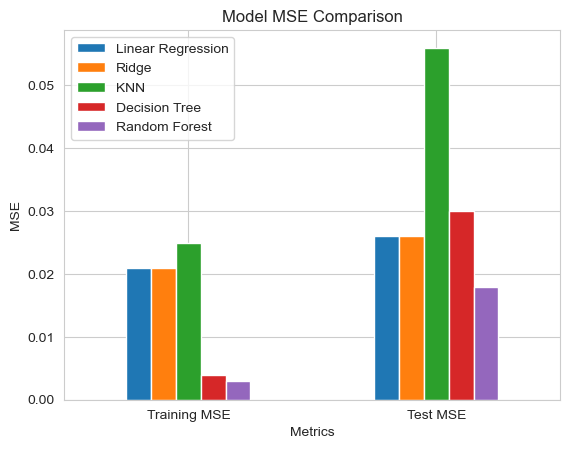

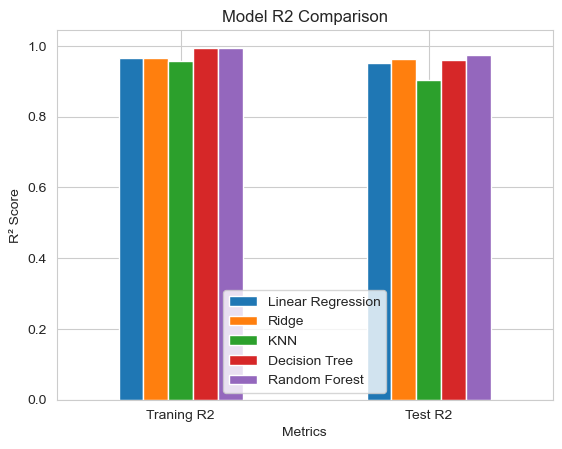

In [64]:
mse = performance[performance['Metrics'].str.contains('MSE')]
r2 = performance[performance['Metrics'].str.contains('R2')]

# Plotting MSE
mse.set_index('Metrics').plot(kind='bar')
plt.title('Model MSE Comparison')
plt.ylabel('MSE')
plt.xticks(rotation=0)
plt.show()

# Plotting R2
r2.set_index('Metrics').plot(kind='bar')
plt.title('Model R2 Comparison')
plt.ylabel('R² Score')
plt.xticks(rotation=0)
plt.show()


Based on the performance of these models, we can see that the ***Random Forest Regressor*** performs the best, with the lowest MSE and highest R2 score. On the other hand, the ***KNN Regressor*** seems to be the least performing model.